Notebook that plots raw 12-lead ECG waveformas into a format more familiar to physicians. Update data_directory and file_id. 

Requires biosppy library for now -- but not really using anything critical from that package except for band-pass filter which can be easily subbed.

In [1]:
from collections import defaultdict
import h5py
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)


from biosppy.signals import ecg

# IPython imports
from IPython.display import Image

/anaconda3/envs/ml4cvd/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#DATA_DIRECTORY = '/Users/pbatra/broad/local_data_sets/tensors/test/2019-03-21'
DATA_DIRECTORY = '/Users/pbatra/broad/local_data_sets/tensors/test/2019-04-26'
leads = {} # dict[name] -> array
file_id = '1000387.hd5'
with h5py.File(os.path.join(DATA_DIRECTORY, file_id)) as hd5:
        for field in list(hd5['ecg_rest'].keys()):
                leads[field] = list(hd5['ecg_rest'][field])

**Biosppy exploration**
* filtering library for a variety of signals, [documentation](https://biosppy.readthedocs.io/en/stable/)
* ecg filtering is meant to be for a single lead only -- does that throw away a lot of useful information across 12 leads?
* also can extract very interesting features like filtered signal, r-preaks, templtes, heartbeat templates, heart rate reference, intstantaneous heart rate

**details of filtering**
* looks like the [ecg.ecg](https://github.com/PIA-Group/BioSPPy/blob/212c3dcbdb1ec43b70ba7199deb5eb22bcb78fd0/biosppy/signals/ecg.py) function applies, using [tools.filter_signal](https://github.com/PIA-Group/BioSPPy/blob/212c3dcbdb1ec43b70ba7199deb5eb22bcb78fd0/biosppy/signals/tools.py), by default (most of these are easily modifiable with alternative defaults)  
    * Finite Impulse Response filter ('FIR')
    * bandpass (low-pass, high-pass, band-pass, band-stop all available), 
    * order of the filter is adjustable and set to 0.3 * sampling rate 
    * between 3 and 45 HZ

**Plotting needs:**
* boxes are 1mm x 1mm, 0.04 sec x .1mV 
* horizontal scale is whatever length you want -- (looks like default is 60 boxes)
* vertical scale is 30 boxes, but they can run into each other


**Raw Data**
* lots of fields in raw xml
* extracted is just lead waveform
* for each strip, following is true: sample_rate = 500 Hz, 5000 counts, units (uVperLsb) 5
* for median strips, 600 counts, 500 hz, 5 uVper LSB, first last valid marks
* Vector Loops?
* Full disclosure data? 
* Also have event time stamps

median_I 600
median_II 600
median_III 600
median_V1 600
median_V2 600
median_V3 600
median_V4 600
median_V5 600
median_V6 600
median_aVF 600
median_aVL 600
median_aVR 600
strip_I 5000


/anaconda3/envs/ml4cvd/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/anaconda3/envs/ml4cvd/lib/python3.6/site-packages/scipy/signal/signaltools.py:1333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/envs/ml4cvd/lib/python3.6/site-packages/scipy/signal/signaltools.py:1336: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inter

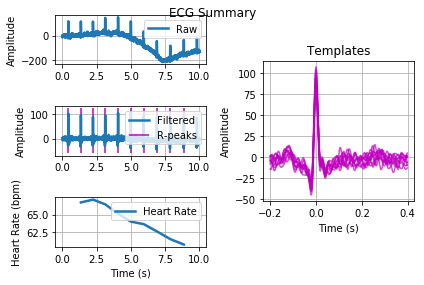

strip_II 5000


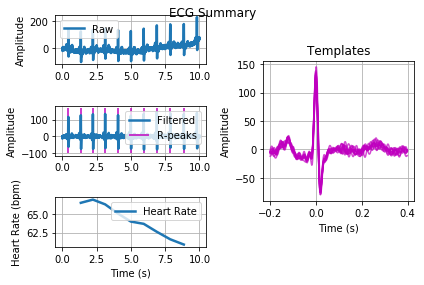

strip_III 5000


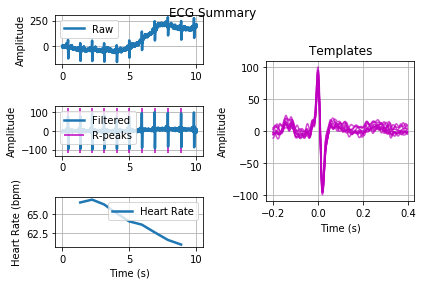

strip_V1 5000


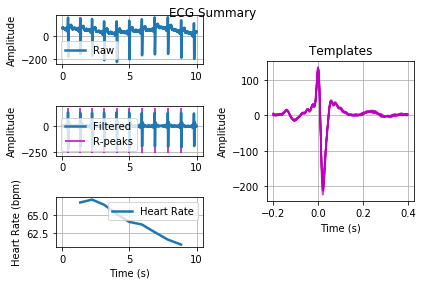

strip_V2 5000


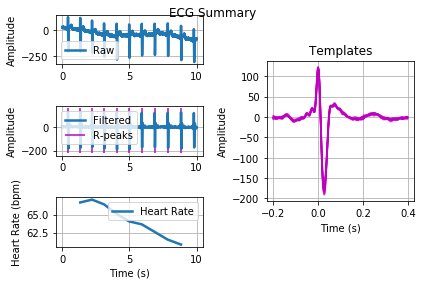

strip_V3 5000


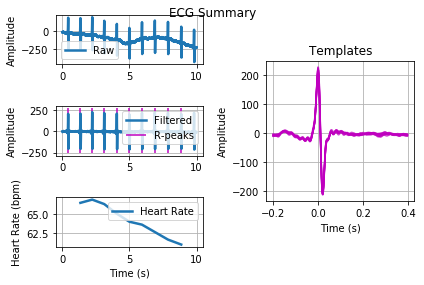

strip_V4 5000


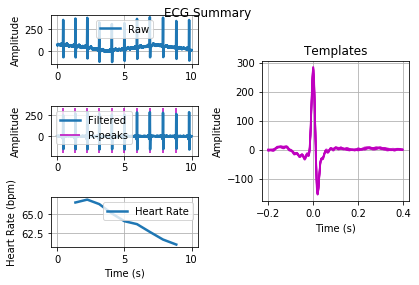

strip_V5 5000


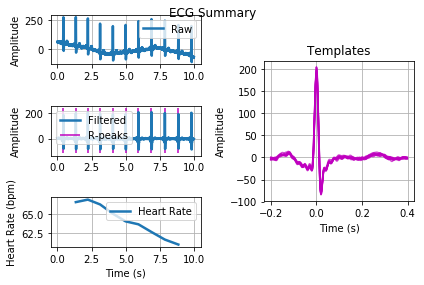

strip_V6 5000


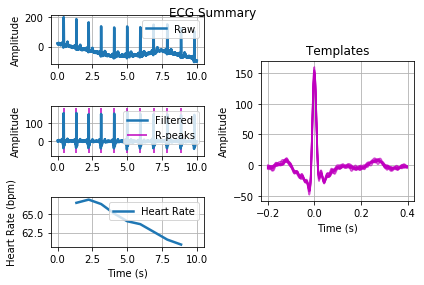

strip_aVF 5000


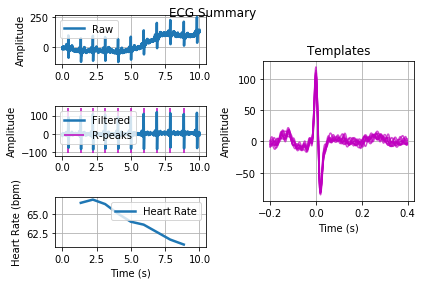

strip_aVL 5000


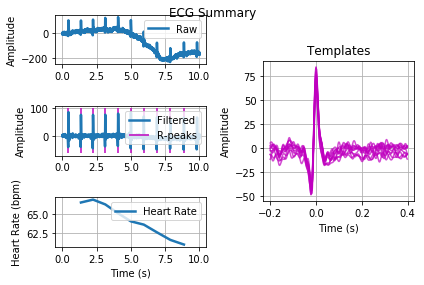

strip_aVR 5000


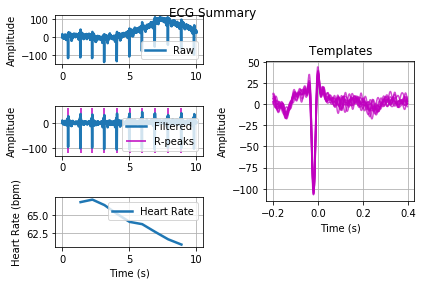

In [3]:
twelve_leads = defaultdict(dict)
for key, data in leads.items():
    print(key, len(data))
    if len(data) == 5000:
        twelve_leads[key]['raw']=leads[key]
        (twelve_leads[key]['ts_reference'], twelve_leads[key]['filtered'], twelve_leads[key]['rpeaks'], 
         twelve_leads[key]['template_ts'], twelve_leads[key]['templates'], twelve_leads[key]['heart_rate_ts'], 
         twelve_leads[key]['heart_rate']) = ecg.ecg(signal=leads[key], sampling_rate = 500.)
        
    

/anaconda3/envs/ml4cvd/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


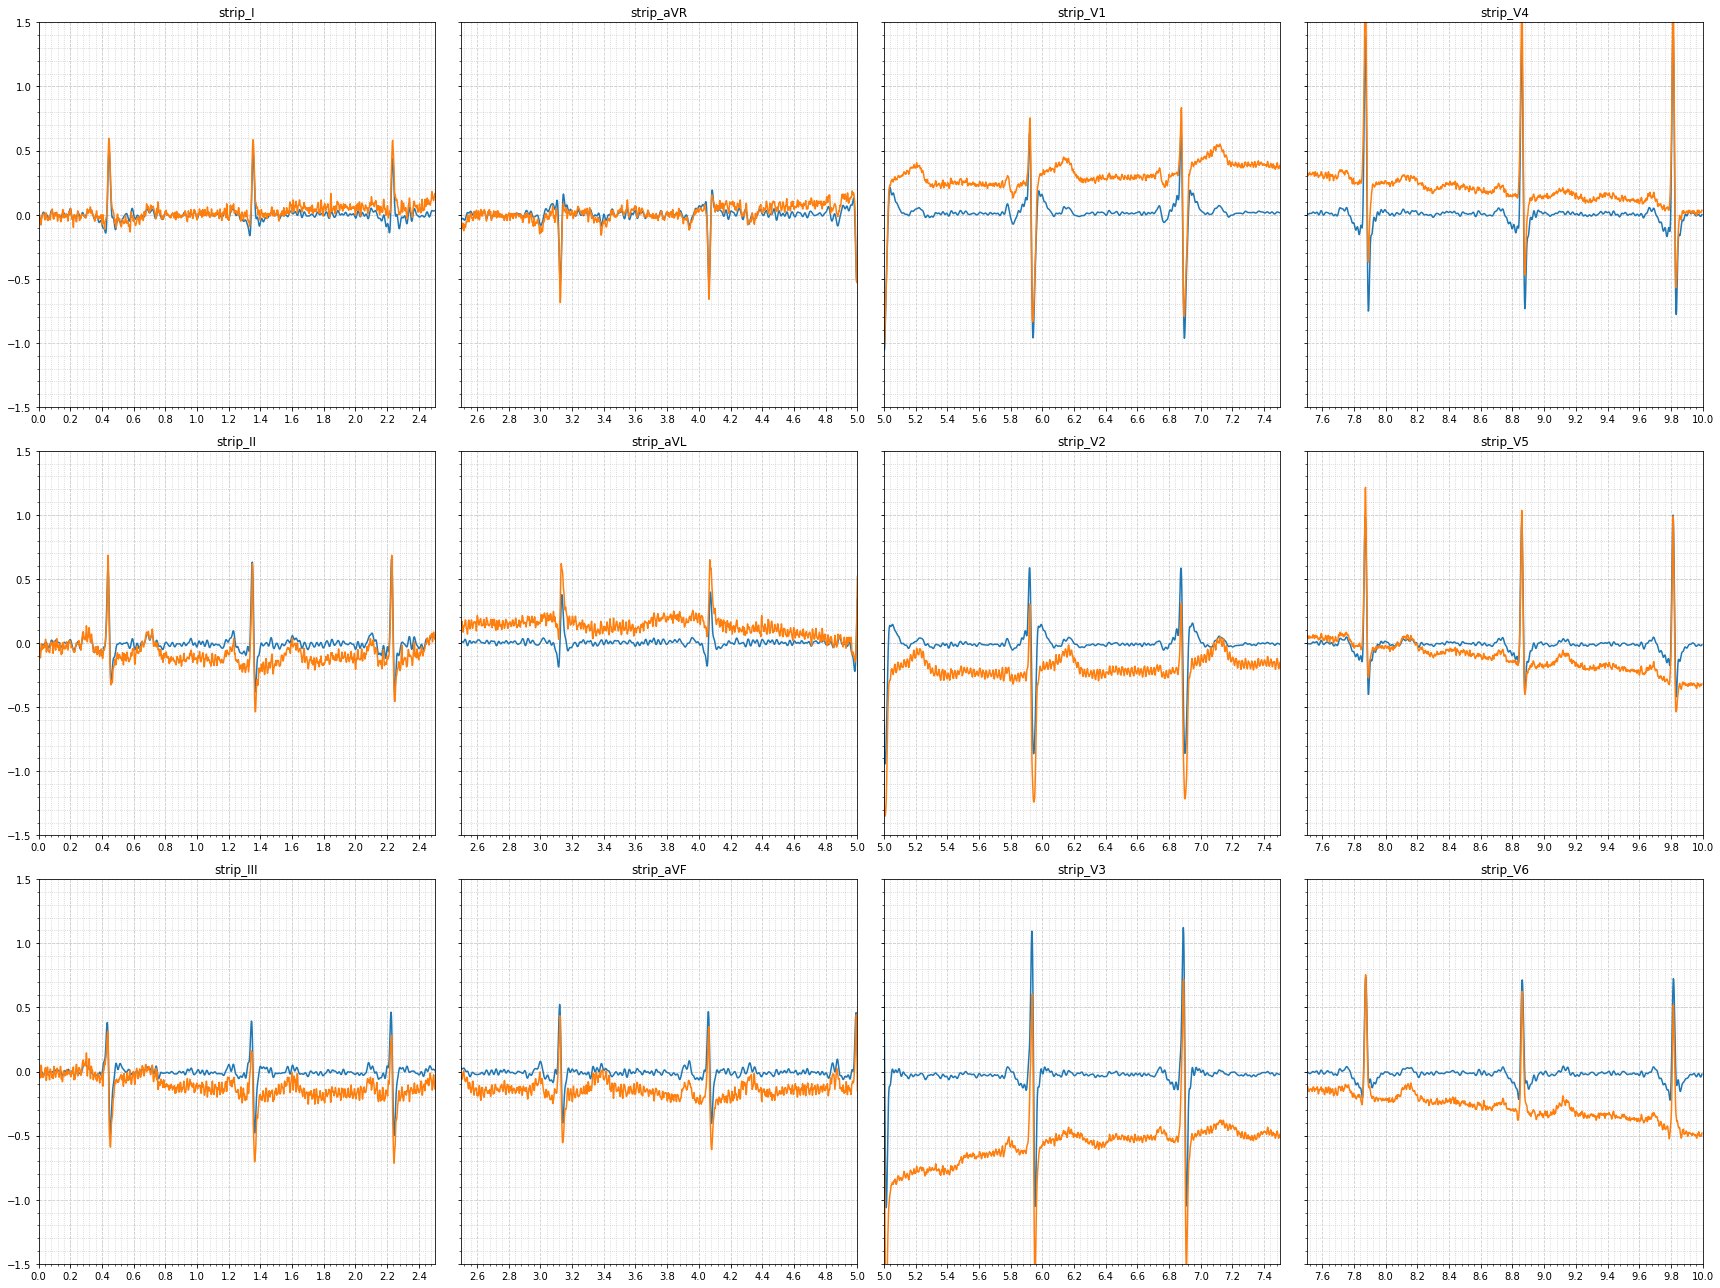

In [4]:
#plt.plot()
#plot will be in seconds vs mV, boxes are 
sec_per_box = 0.04
mv_per_box = .1
time_interval = 2.5 #time-interval per plot in seconds. ts_Reference data is in s, voltage measurement is 5 uv per lsb
raw_scale = 0.005 # convert to mV

fig, ax = plt.subplots(nrows=3, ncols=4, sharey='row', figsize=(24,18), tight_layout=True)
lead_mapping=np.array([['strip_I','strip_aVR', 'strip_V1', 'strip_V4'],
              ['strip_II','strip_aVL', 'strip_V2', 'strip_V5'],
              ['strip_III','strip_aVF', 'strip_V3', 'strip_V6'],
             ])


for i in range(0,3):
    for j in range(0,4):
        lead_name = lead_mapping[i,j]
        lead = twelve_leads[lead_name]
        ax[i,j].set_xlim(j*time_interval,(j+1)*time_interval)
        ax[i,j].set_ylim(-1.5, 1.5) #-1.5mV -> 1.5mV
        ax[i,j].xaxis.set_major_locator(MultipleLocator(0.2)) #major grids at every .2sec = 5 * 0.04 sec
        ax[i,j].yaxis.set_major_locator(MultipleLocator(0.5))  #major grids at every .5mV 

        ax[i,j].xaxis.set_minor_locator(AutoMinorLocator(5))
        ax[i,j].yaxis.set_minor_locator(AutoMinorLocator(5))

        ax[i,j].grid(which='major', color='#CCCCCC', linestyle='--')
        ax[i,j].grid(which='minor', color='#CCCCCC', linestyle=':')
        #normalize data in muv
        ax[i,j].plot(lead['ts_reference'], [elem_ * raw_scale for elem_ in lead['filtered']])
        
        ax[i,j].plot(lead['ts_reference'], [elem_ * raw_scale for elem_ in lead['raw']])
        ax[i,j].set_title(lead_name)
#plt.show()
fig.savefig(f'{file_id}.pdf')
#major_ticks_time = np.arrange(0, max_time, int(max_time/0.04))
#major_ticks_mv = 
#plt.grid(True, xdata = [0.04, 0.08], ydata =[50,100])
#plt.plot(ts_reference, leads['strip_I'])
#plt.plot(ts_reference, filtered)